<a href="https://colab.research.google.com/github/kiran74-ds/computer_vision/blob/master/Crop_and_weed_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective 

Build a system to classify and detect crops and weeds.

# Load the Data

In [ ]:
# load data from kaggle and install necessary modules
import os
if not os.path.exists('images'):
  !pip install -q --upgrade torch_snippets
  from google.colab import files
  files.upload() # upload kaggle.json
  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d ravirajsinh45/crop-and-weed-detection-data-with-bounding-boxes


Saving kaggle.json to kaggle.json
kaggle.json
 99% 78.0M/79.2M [00:01<00:00, 35.4MB/s]
100% 79.2M/79.2M [00:01<00:00, 49.8MB/s]


In [ ]:
ls

crop-and-weed-detection-data-with-bounding-boxes.zip  sample_data/


In [ ]:
  !unzip -qq crop-and-weed-detection-data-with-bounding-boxes.zip
  !rm crop-and-weed-detection-data-with-bounding-boxes.zip

In [ ]:
ls

agri_data/  classes.txt  sample_data/


In [ ]:
ls agri_data/data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import tqdm
from sklearn.model_selection import train_test_split
import glob
import numpy as np
import logging
from torch_snippets import *

In [ ]:
df = pd.DataFrame()
i = 0
for file in os.listdir('agri_data/data'):
    if file.endswith('txt'):
        with open('agri_data/data/'+ file, 'r') as f:
            txt = f.read()
            image_info = txt.split('\n')
            image_info = image_info[:-1]
            for name in image_info:
                txt = name.split(' ')
                df.loc[i, 'image_path'] = 'agri_data/data/' + file.split('.')[0] + '.jpeg'
                df.loc[i, 'ImageID'] = file[:-4]
                df.loc[i, 'class'] = txt[0]
                df.loc[i, 'x'] = txt[1]
                df.loc[i, 'y'] = txt[2]
                df.loc[i, 'w'] = txt[3]
                df.loc[i, 'h'] = txt[4]
                i += 1
df = df.reset_index(drop='index')
df['class_name'] = df['class'].map({'0':'Crop', '1':'Weed'})

In [ ]:
df

,image_path,ImageID,class,x,y,w,h,class_name
0,agri_data/data/agri_0_9032.jpeg,agri_0_9032,0,0.500977,0.609375,0.939453,0.433594,Crop
1,agri_data/data/agri_0_8675.jpeg,agri_0_8675,1,0.510742,0.404297,0.630859,0.738281,Weed
2,agri_data/data/agri_0_6993.jpeg,agri_0_6993,1,0.566406,0.383789,0.691406,0.623047,Weed
3,agri_data/data/agri_0_5981.jpeg,agri_0_5981,1,0.560547,0.403320,0.667969,0.630859,Weed
4,agri_data/data/agri_0_6097.jpeg,agri_0_6097,0,0.493164,0.472656,0.927734,0.921875,Crop
...,...,...,...,...,...,...,...,...
2067,agri_data/data/agri_0_8663.jpeg,agri_0_8663,1,0.541016,0.537109,0.804688,0.796875,Weed
2068,agri_data/data/agri_0_484.jpeg,agri_0_484,0,0.530273,0.509766,0.658203,0.726562,Crop
2069,agri_data/data/agri_0_8741.jpeg,agri_0_8741,0,0.466797,0.529297,0.804688,0.621094,Crop
2070,agri_data/data/agri_0_7322.jpeg,agri_0_7322,0,0.505859,0.506836,0.843750,0.814453,Crop


In [ ]:
df['x' ]= df['x'].astype('float')
df['y' ]= df['y'].astype('float')
df['w' ]= df['w'].astype('float')
df['h' ]= df['h'].astype('float')

df['x_min'] = (df['x'] - df['w']/2) * 512
df['y_min'] = (df['y'] - df['h']/2) * 512
df['x_max'] = (df['x'] + df['w']/2) * 512
df['y_max'] = (df['y'] + df['h']/2) * 512


df['x_min'] = df['x_min'].astype('int')
df['y_min'] = df['y_min'].astype('int')
df['x_max'] = df['x_max'].astype('int')
df['y_max'] = df['y_max'].astype('int')

In [ ]:
df

,image_path,ImageID,class,x,y,w,h,class_name,x_min,y_min,x_max,y_max
0,agri_data/data/agri_0_9032.jpeg,agri_0_9032,0,0.500977,0.609375,0.939453,0.433594,Crop,16,200,497,423
1,agri_data/data/agri_0_8675.jpeg,agri_0_8675,1,0.510742,0.404297,0.630859,0.738281,Weed,100,18,422,396
2,agri_data/data/agri_0_6993.jpeg,agri_0_6993,1,0.566406,0.383789,0.691406,0.623047,Weed,112,36,466,356
3,agri_data/data/agri_0_5981.jpeg,agri_0_5981,1,0.560547,0.403320,0.667969,0.630859,Weed,116,44,458,367
4,agri_data/data/agri_0_6097.jpeg,agri_0_6097,0,0.493164,0.472656,0.927734,0.921875,Crop,15,5,489,477
...,...,...,...,...,...,...,...,...,...,...,...,...
2067,agri_data/data/agri_0_8663.jpeg,agri_0_8663,1,0.541016,0.537109,0.804688,0.796875,Weed,71,70,483,478
2068,agri_data/data/agri_0_484.jpeg,agri_0_484,0,0.530273,0.509766,0.658203,0.726562,Crop,102,75,439,447
2069,agri_data/data/agri_0_8741.jpeg,agri_0_8741,0,0.466797,0.529297,0.804688,0.621094,Crop,32,112,445,430
2070,agri_data/data/agri_0_7322.jpeg,agri_0_7322,0,0.505859,0.506836,0.843750,0.814453,Crop,42,51,474,468


# Visualizing Data

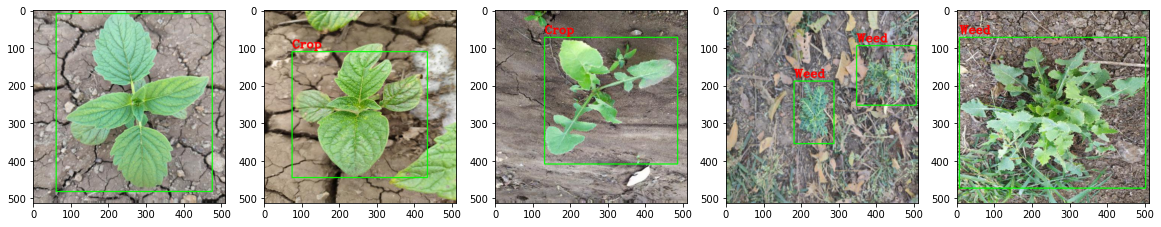

In [ ]:
random_indexes = np.random.randint(10, 1000, 5)
plt.figure(figsize=(20,20))
for i, test_index in enumerate(random_indexes):
    plt.subplot(1,len(random_indexes), i+1)
    test_image = df.loc[test_index, 'image_path']
    test_df = df[df.image_path == test_image].reset_index(drop='index')
    img = plt.imread(test_image)

    for i in range(test_df.shape[0]):
        x1, y1, x2, y2 = test_df.loc[i, 'x_min'], test_df.loc[i, 'y_min'], test_df.loc[i, 'x_max'], test_df.loc[i, 'y_max']
        rec = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
        cv2.putText(rec, test_df.loc[i, 'class_name'], (x1, y1-10), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        plt.imshow(img)

In [ ]:
label2target = {l:t+1 for t,l in enumerate(df['class_name'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [ ]:
label2target

{'Crop': 1, 'Weed': 2, 'background': 0}

In [ ]:
target2label

{0: 'background', 1: 'Crop', 2: 'Weed'}

# DataSet Preparation

In [ ]:
import collections, os
from PIL import Image
import torch
IMAGE_ROOT = 'data'

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.float()
    
class OpenDataset(torch.utils.data.Dataset):
    w, h = 512, 512
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        logger.info(f'{len(self)} items loaded')
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = df[df.ImageID==image_id]['image_path'].iloc[0]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['class_name'].values.tolist()
        data = data[['x_min','y_min','x_max','y_max']].values
        boxes = data.astype(np.uint32).tolist() 
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()

        img = preprocess_image(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.2, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
print(len(trn_df)), print(len(val_df))

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)

2020-08-09 09:39:51.512 | INFO     | __main__:__init__:17 - 1040 items loaded
2020-08-09 09:39:51.513 | INFO     | __main__:__init__:17 - 260 items loaded


1672
400


# Build a model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()

    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the entire function below
def validate_batch(inputs, model, optimizer):
    model.train() # to obtain the losses, model needs to be in train mode only

    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

# Model Training

In [ ]:
def main(n_epochs=1):

  device = 'cuda'

  model = get_model().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                              momentum=0.9, weight_decay=0.0005)
  log = Report(n_epochs)
  for epoch in range(n_epochs):
      if epoch==2: optimizer = optim.SGD(model.parameters(), lr=5e-4)
      if epoch==3: optimizer = optim.SGD(model.parameters(), lr=1e-4)
      if epoch==4: optimizer = optim.SGD(model.parameters(), lr=5e-5)

      _n = len(train_loader)
      for ix, inputs in enumerate(train_loader):
          loss, losses = train_batch(inputs, model, optimizer)
          loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
              [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
          pos = (epoch + (ix+1)/_n)
          log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                    trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                    trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

      _n = len(test_loader)
      for ix,inputs in enumerate(test_loader):
          loss, losses = validate_batch(inputs, model, optimizer)
          loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
          pos = (epoch + (ix+1)/_n)
          log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                    val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                    val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
      #if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)


  torch.save(model.state_dict(), 'faster-rcnn.weights')
  return model, log

In [ ]:
model, log = main()

EPOCH: 1.000	val_loss: 0.100	val_loc_loss: 0.035	val_regr_loss: 0.062	val_objectness_loss: 0.001	val_rpn_box_reg_loss: 0.002	(238.71s - 0.00s remaining)

# Inference

In [ ]:
from torchvision.ops import nms

# in validation mode, model will directly give BBS, Confs and classes as output
model.eval().cpu()

def decode_output(output, apply_nms=False):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()

    if apply_nms:
      ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.01)
      bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
      if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]

    else:
        bbs, confs, labels = [tensor for tensor in [bbs, confs, labels]]


    return bbs.tolist(), confs.tolist(), labels.tolist()


In [ ]:
for ix, (images, targets) in enumerate(test_loader):
  if ix==2: break
  images = [im.cpu() for im in images]
  outputs = model(images)
  for ix, output in enumerate(outputs):
    bbs, confs, labels = decode_output(output)
    info = [f'{l}:{c:.2f}' for l,c in zip(labels, confs)]
    show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=info, sz=5)

# Inference After Applying Non Maxima Suppression

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


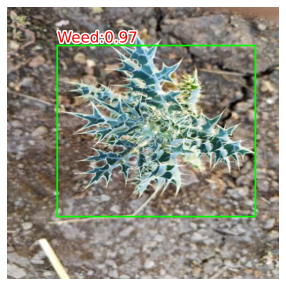

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


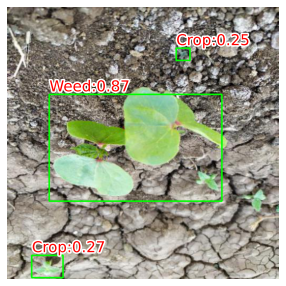

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


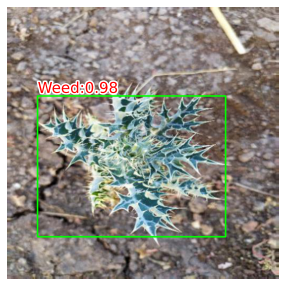

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


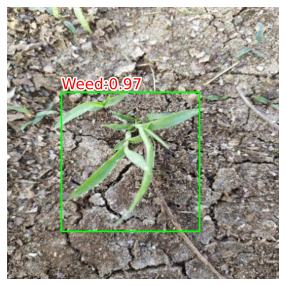

In [ ]:
for ix, (images, targets) in enumerate(test_loader):
  if ix==2: break
  images = [im.cpu() for im in images]
  outputs = model(images)
  for ix, output in enumerate(outputs):
    bbs, confs, labels = decode_output(output, True)
    info = [f'{l}:{c:.2f}' for l,c in zip(labels, confs)]
    show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=info, sz=5)

# Model ouput after 10 epochs

In [ ]:
model, log = main(n_epochs=10)

EPOCH: 10.000	val_loss: 0.069	val_loc_loss: 0.025	val_regr_loss: 0.042	val_objectness_loss: 0.000	val_rpn_box_reg_loss: 0.002	(2405.23s - 0.00s remaining)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [00:00<00:00, 324.73it/s]


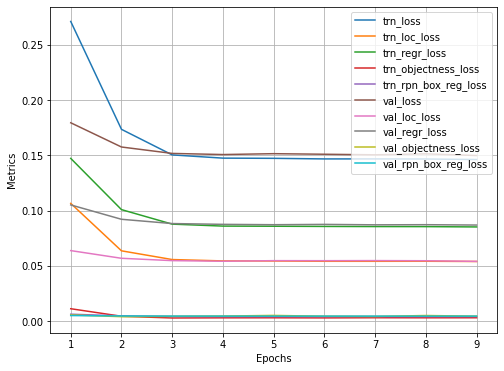

In [ ]:
log.plot_epochs()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


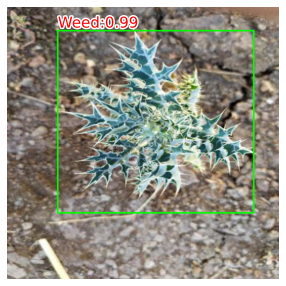

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


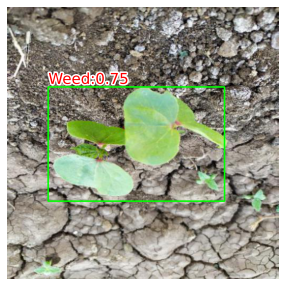

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


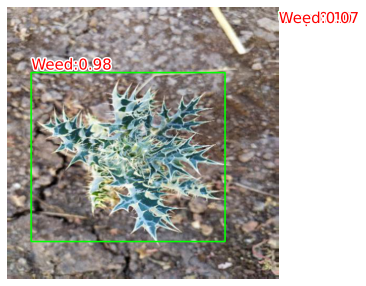

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


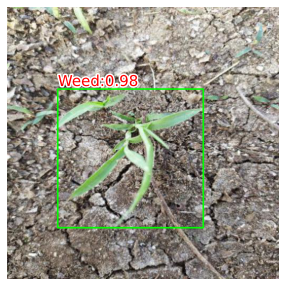

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


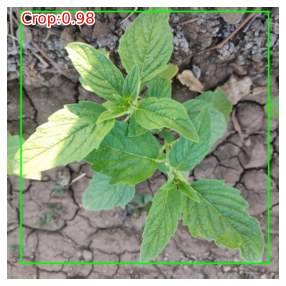

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


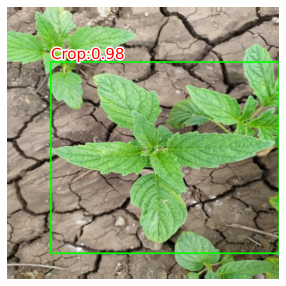

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


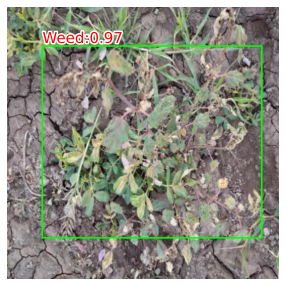

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


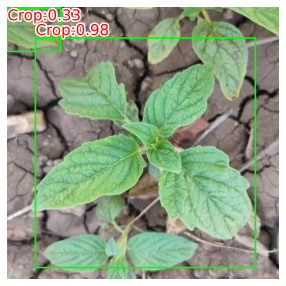

In [ ]:
model.eval().cpu()
for ix, (images, targets) in enumerate(test_loader):
  if ix==2: break
  images = [im.cpu() for im in images]
  outputs = model(images)
  for ix, output in enumerate(outputs):
    bbs, confs, labels = decode_output(output, True)
    info = [f'{l}:{c:.2f}' for l,c in zip(labels, confs)]
    show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=info, sz=5)